In [ ]:
pip install torchmetrics

In [ ]:
import os
from math import ceil

import cv2 as op
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as f
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torchvision
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Use the 'seaborn' style for plotting
plt.style.use('seaborn')

# Print the version of numpy
print(np.__version__)

# Determine the device to use for PyTorch ('cuda' if available, else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

1.25.2
cpu


<ipython-input-54-344807447aa3>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
PATH = '/content/drive/MyDrive/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
525,/content/drive/MyDrive/dataset/cataract/_398_8...,0
3858,/content/drive/MyDrive/dataset/diabetic_retino...,3
3188,/content/drive/MyDrive/dataset/diabetic_retino...,3
2282,/content/drive/MyDrive/dataset/normal/2388_lef...,2
3006,/content/drive/MyDrive/dataset/normal/3217_lef...,2


<ipython-input-56-3846fdc3d369>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

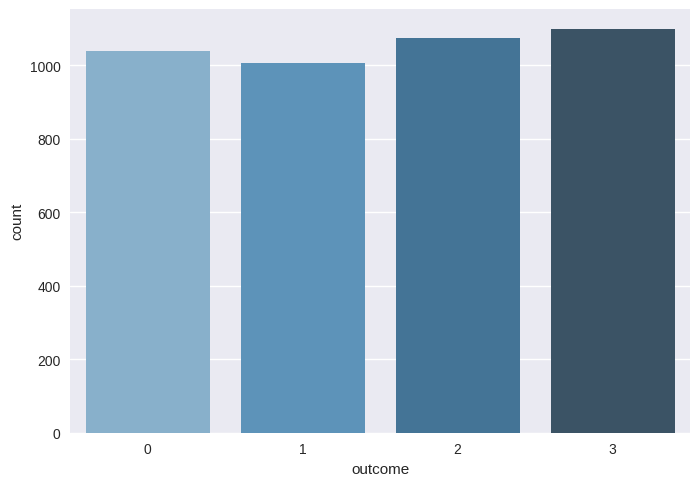

In [ ]:
sns.countplot(x = 'outcome', data = df, palette = 'Blues_d')

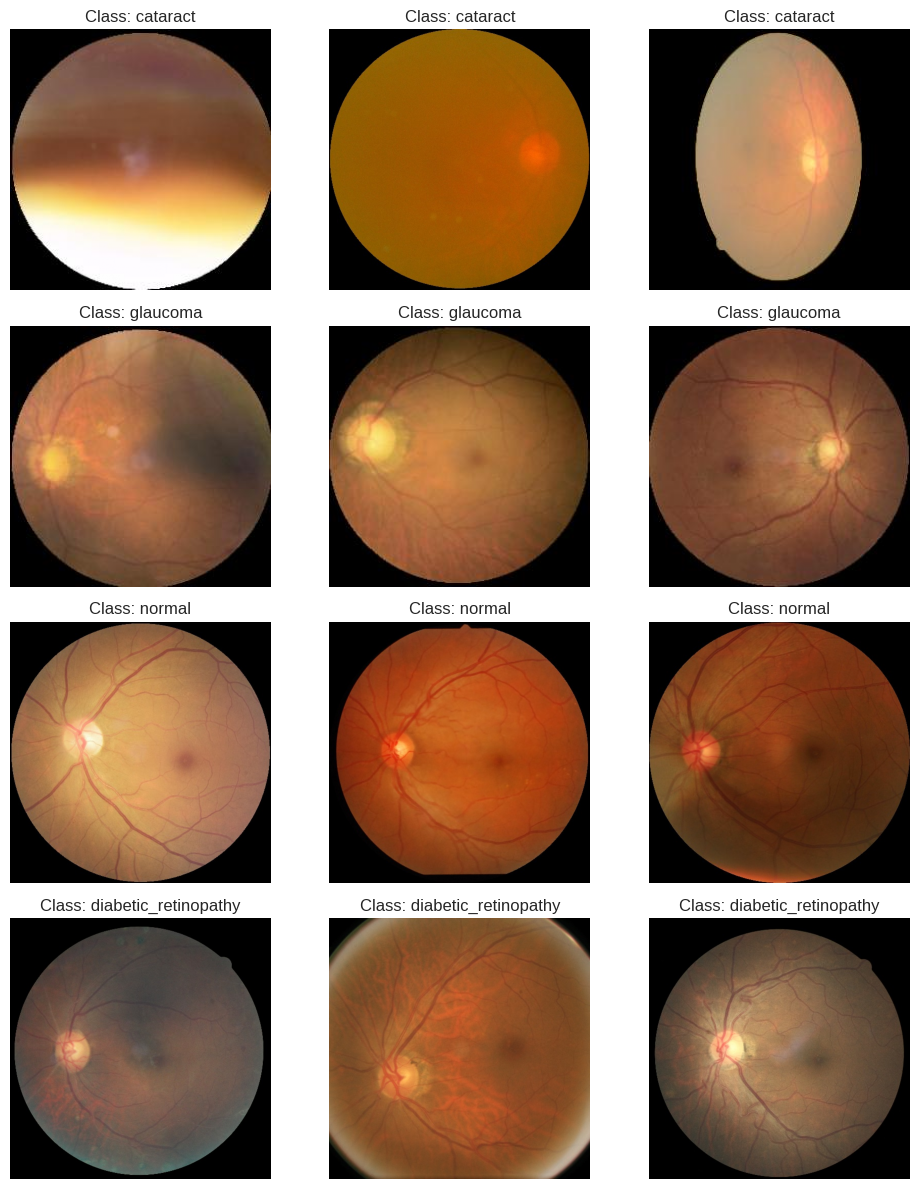

In [ ]:
def load_image(path):
    image = plt.imread(path)
    normalized_image = (image - image.min()) / image.max()
    return normalized_image

fig, ax = plt.subplots(4, 3, figsize=(10, 12))
counter = 0

for i in range(4):
    sample_paths = df[df['outcome'] == i].sample(n=3)['filename']
    for path in sample_paths:
        row = counter // 3
        col = counter % 3
        img = load_image(path)
        ax[row, col].imshow(img)
        ax[row, col].axis('off')
        ax[row, col].set_title(f'Class: {id2label[i]}')
        counter += 1

plt.tight_layout()
plt.show()

In [ ]:
# Define transformations for training and validation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

class EyeDataset(Dataset):
    def __init__(self, dataframe, num_classes, transform=None):
        self.dataframe = dataframe
        self.num_samples = len(self.dataframe)
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        image = plt.imread(image_path)
        label = self.dataframe.iloc[idx, 1]

        # Normalize image
        image = (image - image.min()) / image.max()

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image.to(torch.float32), label


In [ ]:
# Split the dataset into training and validation sets
train_data, val_data = train_test_split(df, test_size=0.15, random_state=28)

# Output the shapes of the resulting datasets
train_data.shape, val_data.shape


((3584, 2), (633, 2))

In [ ]:
# Define constants for number of classes and batch size
NUM_CLASSES = 4
BATCH_SIZE = 128

# Create datasets for training and validation
train_data = EyeDataset(train_data, NUM_CLASSES, train_transform)
val_data = EyeDataset(val_data, NUM_CLASSES, val_transform)

# Initialize data loaders with the datasets
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:

first_batch0,first_batch1 = next(iter(train_loader))


# Delete the batch to free up memory
del (first_batch0)
del (first_batch1)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained=True)

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()


    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params': self.base.parameters(), 'lr': 3e-5},
            {'params': self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss += l.item()
            acc += a.item()

        return loss / len(loader), acc / len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), [train_loss, val_loss, train_acc, val_acc]):
                self.history[item].append(value)

            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [ ]:
trainer = Trainer(train_loader=train_loader, val_loader=val_loader, device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(trainer.model.base, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
import google.colab.drive as drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainer.train(epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.803 acc: 0.685] Val: [loss: 0.483 acc:0.815]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.401 acc: 0.850] Val: [loss: 0.375 acc:0.867]


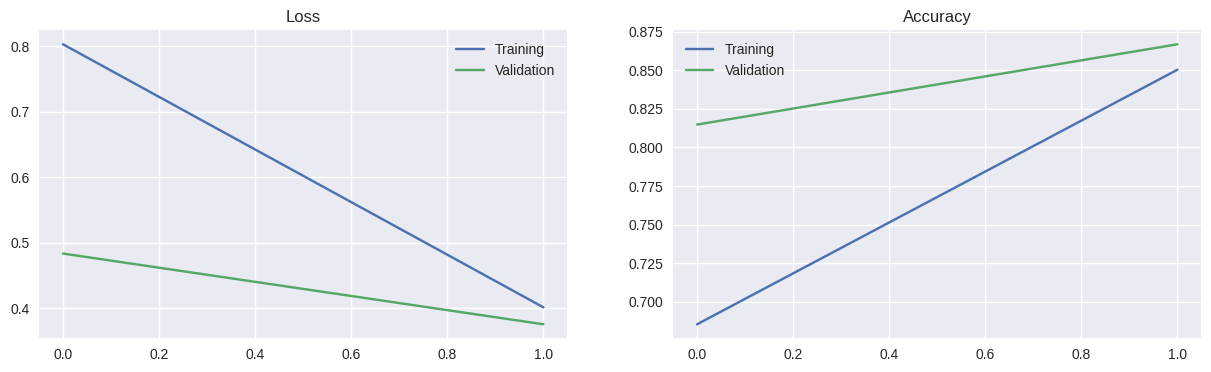

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label='Training')
plt.plot(trainer.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label='Training')
plt.plot(trainer.history['val_acc'], label='Validation')
plt.legend()

In [ ]:
preds = []
true = []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis=1).detach().cpu().numpy()
        preds += list(pred)
        true += list(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

Text(0.5, 1.0, 'Confusion Matrix')

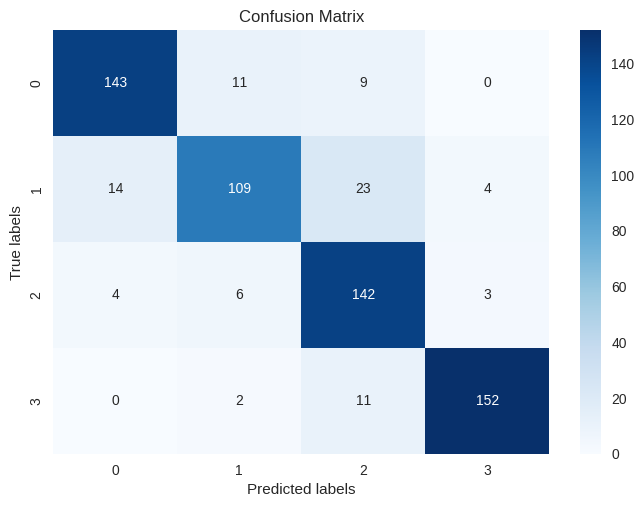

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true, preds)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

# Set labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')


In [ ]:
# Generate and print the classification report
print(classification_report(true, preds, target_names=label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.89      0.88      0.88       163
            glaucoma       0.85      0.73      0.78       150
              normal       0.77      0.92      0.84       155
diabetic_retinopathy       0.96      0.92      0.94       165

            accuracy                           0.86       633
           macro avg       0.87      0.86      0.86       633
        weighted avg       0.87      0.86      0.86       633

